FINM33601 - Fixed Income Derivatives

Homework 2

University of Chicago


Author: Laurent Lanteigne

ID: 12279717

Date: April 29th, 2021

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy import optimize
import copy
import datetime
import warnings
%matplotlib inline
warnings.simplefilter("ignore")
pd.set_option("precision", 6)
plt.style.use('fivethirtyeight')

In [2]:
df_swap = pd.read_excel('bootstrap_data.xlsx')
df_swap.head()

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote
0,USD SOFR Rate,O/N,2020-09-14,2020-09-15,0.000900
1,USD SOFR Fixed/Float Swap,1 Week,2020-09-16,2020-09-23,0.000770
2,USD SOFR Fixed/Float Swap,2 Weeks,2020-09-16,2020-09-30,0.000758
3,USD SOFR Fixed/Float Swap,3 Weeks,2020-09-16,2020-10-07,0.000769
4,USD SOFR Fixed/Float Swap,1 Month,2020-09-16,2020-10-16,0.000780


Time between knots: $$\Delta t_i = (t_i - t_{i-t})$$

In [3]:
df_swap['Basis'] = (df_swap['Accrual End'] - df_swap['Accrual Begin']).apply(lambda x: x.days/360)
df_swap['Knots'] = (df_swap['Accrual End'] - df_swap['Accrual Begin'][0]).apply(lambda x: x.days/365)
df_swap['Discrete Forward Rate'] = 0 
df_swap['time_btw_knots'] = df_swap['Knots'].diff()
df_swap.fillna(0, inplace=True)

Let's start by finding the first discrete forward rate for the bootstrap.Then extend to get the discrete rates for the first year.

Discrete forward rate for period 0: $$ f(0,0,t_1) = \frac{1}{t_1}\log\left( 1+ R(0,0,t_1)\right) $$

In [4]:
df_swap['Discrete Forward Rate'].iloc[0] = ((1 / df_swap['Knots'][0]) * np.log(1 + df_swap['Basis'][0] * df_swap['Quote'][0]))
df_swap.iloc[0].to_frame()

,0
Instrument Type,USD SOFR Rate
Tenor,O/N
Accrual Begin,2020-09-14 00:00:00
Accrual End,2020-09-15 00:00:00
Quote,0.0009
Basis,0.002778
Knots,0.00274
Discrete Forward Rate,0.000912
time_btw_knots,0.0


Discrete forward rate for period <1Y: 

Basis : $\tau_i$
$$
f(0,t_{i-1},t_i)=\frac{1}{t_i-t_{i-1}}\log\left(\frac{1+\tau_i R(0,t',t_i)}{1+\tau_{i-1} R(0,t',t_{i-1})}\right)
$$
$$
f(0,t_{i-1},t_i)=\frac{1}{\Delta t_i}\log\left(1+\tau_i R(0,t',t_i)\right) - \log\left(1+\tau_{i-1} R(0,t',t_{i-1})\right)
$$
$$
f(0,t_{i-1},t_i)=\frac{1}{\Delta t_i}\cdot (\Delta \log_i \left(1+\tau_i R(0,t',t_i)\right) 
$$

In [5]:
df_swap['log_basis_times_quotes'] = (np.log(1+df_swap['Basis'] * df_swap['Quote']))
df_swap['Discrete Forward Rate'][1:16] = (1/df_swap['time_btw_knots'][1:16].values) * df_swap['log_basis_times_quotes'][0:16].diff().shift(-1).dropna().values
df_swap[:16]

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes
0,USD SOFR Rate,O/N,2020-09-14,2020-09-15,0.000900,0.002778,0.002740,0.000912,0.000000,0.000002
1,USD SOFR Fixed/Float Swap,1 Week,2020-09-16,2020-09-23,0.000770,0.019444,0.024658,0.000569,0.021918,0.000015
2,USD SOFR Fixed/Float Swap,2 Weeks,2020-09-16,2020-09-30,0.000758,0.038889,0.043836,0.000756,0.019178,0.000029
3,USD SOFR Fixed/Float Swap,3 Weeks,2020-09-16,2020-10-07,0.000769,0.058333,0.063014,0.000802,0.019178,0.000045
4,USD SOFR Fixed/Float Swap,1 Month,2020-09-16,2020-10-16,0.000780,0.083333,0.087671,0.000817,0.024658,0.000065
5,USD SOFR Fixed/Float Swap,2 Months,2020-09-16,2020-11-16,0.000766,0.169444,0.172603,0.000763,0.084932,0.000130
6,USD SOFR Fixed/Float Swap,3 Months,2020-09-16,2020-12-16,0.000766,0.252778,0.254795,0.000777,0.082192,0.000194
7,USD SOFR Fixed/Float Swap,4 Months,2020-09-16,2021-01-19,0.000811,0.347222,0.347945,0.000944,0.093151,0.000282
8,USD SOFR Fixed/Float Swap,5 Months,2020-09-16,2021-02-16,0.000775,0.425000,0.424658,0.000623,0.076712,0.000329
9,USD SOFR Fixed/Float Swap,6 Months,2020-09-16,2021-03-16,0.000750,0.502778,0.501370,0.000622,0.076712,0.000377


We need to correct the first one (1 Week).

In [6]:
df_swap['Discrete Forward Rate'].loc[1]= (365/7) * df_swap['log_basis_times_quotes'].loc[1]
df_swap.head()

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes
0,USD SOFR Rate,O/N,2020-09-14,2020-09-15,0.000900,0.002778,0.002740,0.000912,0.000000,0.000002
1,USD SOFR Fixed/Float Swap,1 Week,2020-09-16,2020-09-23,0.000770,0.019444,0.024658,0.000781,0.021918,0.000015
2,USD SOFR Fixed/Float Swap,2 Weeks,2020-09-16,2020-09-30,0.000758,0.038889,0.043836,0.000756,0.019178,0.000029
3,USD SOFR Fixed/Float Swap,3 Weeks,2020-09-16,2020-10-07,0.000769,0.058333,0.063014,0.000802,0.019178,0.000045
4,USD SOFR Fixed/Float Swap,1 Month,2020-09-16,2020-10-16,0.000780,0.083333,0.087671,0.000817,0.024658,0.000065


For the discrete forward rate after 1Y, we have the following formula:

$$
c = \frac{P(0,t',t_{i-1})^{-1} - e^{-f(0,t_{i-1},t_i)(t_i-t_{i-1})}}{\sum_{j=1}^{\bar{m}}\tau_jP(0,s_j,t_{i-1})^{-1} + \sum_{j=\bar{m}+1}^{m}\tau_je^{-f(0,t_{i-1},t_i)(s_j-t_{i-1})}} = R(0,t',t_i)
$$

Making some simplifications such as $\bar{m}+1 = m = i$, since we are bootstrapping one step forward. Letting $s_j \in \{t_i\}$.

$$
c = \frac{P(0,t',t_{i-1})^{-1} - e^{-f(0,t_{i-1},t_i)(t_i-t_{i-2})}}{\sum_{j=1}^{i-1}\tau_jP(0,s_j,t_{i-1})^{-1} + \tau_ie^{-f(0,t_{i-1},t_i)(t_i-t_{i-1})}} = R(0,t',t_i)
$$

\
$$
P(0,s_j,t_{i-1}) = e^{-f(0,s_j,t_{i-1})(t_{i-1}-s_j)} \rightarrow P(0,t_{i-1},t_i) = e^{-f(0,t_{i-1},t_i)(t_i-t_{i-1})}
$$

$$
P(0,t_{i-1},t_i)^{-1} = \left(e^{-f(0,t_{i-1},t_i)(t_i-t_{i-1})}\right)^{-1} 
$$

In [7]:
df_swap['Discount Factor'] = 1.00
for i in range(1,16):
    df_swap['Discount Factor'].loc[i] = np.exp(-df_swap['time_btw_knots'].loc[i]*df_swap['Discrete Forward Rate'].loc[i])*df_swap['Discount Factor'].loc[i-1]

# Need to know to properly discount 1Y+
discount_rate_9_16 = np.exp(-df_swap['Discrete Forward Rate'].loc[1]*2/365)
df_swap

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
0,USD SOFR Rate,O/N,2020-09-14,2020-09-15,0.000900,0.002778,0.002740,0.000912,0.000000,0.000002,1.000000
1,USD SOFR Fixed/Float Swap,1 Week,2020-09-16,2020-09-23,0.000770,0.019444,0.024658,0.000781,0.021918,0.000015,0.999983
2,USD SOFR Fixed/Float Swap,2 Weeks,2020-09-16,2020-09-30,0.000758,0.038889,0.043836,0.000756,0.019178,0.000029,0.999968
3,USD SOFR Fixed/Float Swap,3 Weeks,2020-09-16,2020-10-07,0.000769,0.058333,0.063014,0.000802,0.019178,0.000045,0.999953
4,USD SOFR Fixed/Float Swap,1 Month,2020-09-16,2020-10-16,0.000780,0.083333,0.087671,0.000817,0.024658,0.000065,0.999933
5,USD SOFR Fixed/Float Swap,2 Months,2020-09-16,2020-11-16,0.000766,0.169444,0.172603,0.000763,0.084932,0.000130,0.999868
6,USD SOFR Fixed/Float Swap,3 Months,2020-09-16,2020-12-16,0.000766,0.252778,0.254795,0.000777,0.082192,0.000194,0.999804
7,USD SOFR Fixed/Float Swap,4 Months,2020-09-16,2021-01-19,0.000811,0.347222,0.347945,0.000944,0.093151,0.000282,0.999716
8,USD SOFR Fixed/Float Swap,5 Months,2020-09-16,2021-02-16,0.000775,0.425000,0.424658,0.000623,0.076712,0.000329,0.999669
9,USD SOFR Fixed/Float Swap,6 Months,2020-09-16,2021-03-16,0.000750,0.502778,0.501370,0.000622,0.076712,0.000377,0.999621


In [8]:
discount_rate_9_16

0.9999957222633954

In [11]:
def discount_factor_finder_one_year(disc_rate, i, j):
    """
    disc_rate: Value we are trying to compute with optimizer
    i: location of the row in dataframe of the value we are computing 
    j: location of the row in dataframe of the last bootstrapped 
    """
        
    term_1 = (discount_rate_9_16-disc_rate)*360
    term_2 = df_swap['Discount Factor'].loc[j]*(df_swap['Accrual End'].loc[j]-df_swap['Accrual Begin'].loc[j]).days
    term_3 = disc_rate*(df_swap['Accrual End'].loc[i]-df_swap['Accrual End'].loc[j]).days
    
    quote = df_swap['Quote'].loc[i]
    
    break_even_rate = term_1/(term_2 + term_3)
    
    
    return quote - break_even_rate

In [12]:
for i in range(16,26):
    if i == 16:
        j = 9
    elif i == 17:
        j = 15
    else:
        j = i-1
    disc_rate = optimize.newton(discount_factor_finder_one_year,1, args=(i,j,))
    df_swap['Discount Factor'].loc[i] = disc_rate
df_swap

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
0,USD SOFR Rate,O/N,2020-09-14,2020-09-15,0.000900,0.002778,0.002740,0.000912,0.000000,0.000002,1.000000
1,USD SOFR Fixed/Float Swap,1 Week,2020-09-16,2020-09-23,0.000770,0.019444,0.024658,0.000781,0.021918,0.000015,0.999983
2,USD SOFR Fixed/Float Swap,2 Weeks,2020-09-16,2020-09-30,0.000758,0.038889,0.043836,0.000756,0.019178,0.000029,0.999968
3,USD SOFR Fixed/Float Swap,3 Weeks,2020-09-16,2020-10-07,0.000769,0.058333,0.063014,0.000802,0.019178,0.000045,0.999953
4,USD SOFR Fixed/Float Swap,1 Month,2020-09-16,2020-10-16,0.000780,0.083333,0.087671,0.000817,0.024658,0.000065,0.999933
5,USD SOFR Fixed/Float Swap,2 Months,2020-09-16,2020-11-16,0.000766,0.169444,0.172603,0.000763,0.084932,0.000130,0.999868
6,USD SOFR Fixed/Float Swap,3 Months,2020-09-16,2020-12-16,0.000766,0.252778,0.254795,0.000777,0.082192,0.000194,0.999804
7,USD SOFR Fixed/Float Swap,4 Months,2020-09-16,2021-01-19,0.000811,0.347222,0.347945,0.000944,0.093151,0.000282,0.999716
8,USD SOFR Fixed/Float Swap,5 Months,2020-09-16,2021-02-16,0.000775,0.425000,0.424658,0.000623,0.076712,0.000329,0.999669
9,USD SOFR Fixed/Float Swap,6 Months,2020-09-16,2021-03-16,0.000750,0.502778,0.501370,0.000622,0.076712,0.000377,0.999621


In [13]:
str_years = []
date_list = []

for i in range(11,51):
    str_years.append("{} years".format(i))
    date_list.append(datetime.datetime(2020+i,9,16))

missing_info = np.array([11,13,14,16,17,18,19,21,22,23,24,26,27,28,29,31,32,33,34,35,36,37,38,39,41,42,43,44,45,46,47,48,49])-11
for j in missing_info:
    dic = {"Instrument Type":"USD SOFR Fixed/Float Swap", "Tenor":str_years[j], "Accrual End":date_list[j]}
    df_swap = df_swap.append(dic, ignore_index = True)
df_swap

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
0,USD SOFR Rate,O/N,2020-09-14,2020-09-15,0.000900,0.002778,0.002740,0.000912,0.000000,0.000002,1.000000
1,USD SOFR Fixed/Float Swap,1 Week,2020-09-16,2020-09-23,0.000770,0.019444,0.024658,0.000781,0.021918,0.000015,0.999983
2,USD SOFR Fixed/Float Swap,2 Weeks,2020-09-16,2020-09-30,0.000758,0.038889,0.043836,0.000756,0.019178,0.000029,0.999968
3,USD SOFR Fixed/Float Swap,3 Weeks,2020-09-16,2020-10-07,0.000769,0.058333,0.063014,0.000802,0.019178,0.000045,0.999953
4,USD SOFR Fixed/Float Swap,1 Month,2020-09-16,2020-10-16,0.000780,0.083333,0.087671,0.000817,0.024658,0.000065,0.999933
...,...,...,...,...,...,...,...,...,...,...,...
61,USD SOFR Fixed/Float Swap,45 years,NaT,2065-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,USD SOFR Fixed/Float Swap,46 years,NaT,2066-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,USD SOFR Fixed/Float Swap,47 years,NaT,2067-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,USD SOFR Fixed/Float Swap,48 years,NaT,2068-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_swap = df_swap.sort_values(by=['Accrual End'])
df_swap = df_swap.reset_index()
df_swap = df_swap.fillna(0)
df_swap = df_swap.drop(['index'] ,axis =1)
df_swap[16:30]

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
16,USD SOFR Fixed/Float Swap,18 Months,2020-09-16 00:00:00,2022-03-16,0.000451,1.516667,1.501370,0.0,0.495890,0.000684,0.999312
17,USD SOFR Fixed/Float Swap,2 Years,2020-09-16 00:00:00,2022-09-16,0.000325,2.027778,2.005479,0.0,0.504110,0.000659,0.999337
18,USD SOFR Fixed/Float Swap,3 Years,2020-09-16 00:00:00,2023-09-18,0.000324,3.047222,3.010959,0.0,1.005479,0.000987,0.999009
19,USD SOFR Fixed/Float Swap,4 Years,2020-09-16 00:00:00,2024-09-16,0.000643,4.058333,4.008219,0.0,0.997260,0.002606,0.997390
20,USD SOFR Fixed/Float Swap,5 Years,2020-09-16 00:00:00,2025-09-16,0.001183,5.072222,5.008219,0.0,1.000000,0.005983,0.994015
21,USD SOFR Fixed/Float Swap,6 Years,2020-09-16 00:00:00,2026-09-16,0.001851,6.086111,6.008219,0.0,1.000000,0.011202,0.988808
22,USD SOFR Fixed/Float Swap,7 Years,2020-09-16 00:00:00,2027-09-16,0.002566,7.100000,7.008219,0.0,1.000000,0.018055,0.981999
23,USD SOFR Fixed/Float Swap,8 Years,2020-09-16 00:00:00,2028-09-18,0.003274,8.122222,8.016438,0.0,1.008219,0.026245,0.973909
24,USD SOFR Fixed/Float Swap,9 Years,2020-09-16 00:00:00,2029-09-17,0.003912,9.133333,9.013699,0.0,0.997260,0.035106,0.965233
25,USD SOFR Fixed/Float Swap,10 Years,2020-09-16 00:00:00,2030-09-16,0.004520,10.144444,10.010959,0.0,0.997260,0.044833,0.955780


In [15]:
def wrapper_function():
    """
    wrapper function that helps extract information from optimizer other than the root
    """
    parameter = {}
    
    def discount_factor_finder_multi_year(disc_rate, i, j, y):
        """
        disc_rate: Value we are trying to compute with optimizer
        i: location of the row in dataframe of the value we are computing 
        j: location of the row in dataframe of the last bootstrapped 
        y: Tenor of the contract we are bootstrapping 
        """
        term_1 = (discount_rate_9_16-disc_rate)*360
        # Year 1 and Year 2 terms 
        term_2 = df_swap['Discount Factor'].loc[15]*(df_swap['Accrual End'].loc[15]-df_swap['Accrual Begin'].loc[15]).days
        term_3 = df_swap['Discount Factor'].loc[17]*(df_swap['Accrual End'].loc[17]-df_swap['Accrual Begin'].loc[17]).days
        
        # Number of years left to bootstrap from 
        years_boot_strap = y - 2 - 1 
        quote = df_swap['Quote'].loc[i]
        
        # Number of years between the previously computed rate
        delta_t = i - j 
        
        # Fixed forward rate for all years in between 
        forward_rate = -(1/delta_t)*(np.log(disc_rate)-np.log(df_swap['Discount Factor'].loc[j]))

        term_4 = 0 
        for k in range(i-years_boot_strap,i):
            if k > j:
                disc_rate_k = np.exp(-(k-j)*forward_rate)*df_swap['Discount Factor'].loc[j]
            else:
                disc_rate_k = df_swap['Discount Factor'].loc[k]

            term_4 += disc_rate_k*(df_swap['Accrual End'].loc[k]-df_swap['Accrual End'].loc[k-1]).days



        break_even_rate = term_1/(term_2 + term_3+ term_4)
        
        parameter['forward_rate'] = forward_rate
        return quote - break_even_rate

    return parameter, discount_factor_finder_multi_year

def bootstrap_dataframe(df_swap, i, j, year):
    """
    j = last known location in dataframe with information about discount factor
    i = location currently bootstrapping 
    year = Tenor of contract
    """
    df = copy.deepcopy(df_swap)
    forward, root_finder = wrapper_function()
    disc_rate = optimize.newton(root_finder,1, args=(i,j,year))
    
    df['Discount Factor'].loc[i] = disc_rate
    df['Discrete Forward Rate'].loc[j+1:i] = [forward['forward_rate']]*(i-j)

    for i in range(j+1,i):
        df['Discount Factor'].loc[i] = np.exp(-forward['forward_rate'])*df['Discount Factor'].loc[i-1]
        
    return df

In [16]:
df_swap.tail()

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
61,USD SOFR Fixed/Float Swap,46 years,0,2066-09-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
62,USD SOFR Fixed/Float Swap,47 years,0,2067-09-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
63,USD SOFR Fixed/Float Swap,48 years,0,2068-09-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
64,USD SOFR Fixed/Float Swap,49 years,0,2069-09-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
65,USD SOFR Fixed/Float Swap,50 Years,2020-09-16 00:00:00,2070-09-16,0.006717,50.727778,50.038356,0.0,10.005479,0.293221,1.0


Let's see if we can compute Y12 now, and iteratively compute the rest of the dataframe. I'll be periodically printing out the dataframe to make sure the function has the right output.

In [17]:
df_swap = bootstrap_dataframe(df_swap, 27, 25, 12)
df_swap[25:31]

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
25,USD SOFR Fixed/Float Swap,10 Years,2020-09-16 00:00:00,2030-09-16,0.00452,10.144444,10.010959,0.000000,0.99726,0.044833,0.955780
26,USD SOFR Fixed/Float Swap,11 years,0,2031-09-16,0.00000,0.000000,0.000000,0.011244,0.00000,0.000000,0.945094
27,USD SOFR Fixed/Float Swap,12 Years,2020-09-16 00:00:00,2032-09-16,0.00547,12.175000,12.013699,0.011244,2.00274,0.064473,0.934527
28,USD SOFR Fixed/Float Swap,13 years,0,2033-09-16,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
29,USD SOFR Fixed/Float Swap,14 years,0,2034-09-16,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
30,USD SOFR Fixed/Float Swap,15 Years,2020-09-16 00:00:00,2035-09-17,0.00650,15.219444,15.016438,0.000000,3.00274,0.094334,1.000000


In [18]:
df_swap = bootstrap_dataframe(df_swap, 30, 27, 15)
df_swap[25:31]

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
25,USD SOFR Fixed/Float Swap,10 Years,2020-09-16 00:00:00,2030-09-16,0.00452,10.144444,10.010959,0.000000,0.99726,0.044833,0.955780
26,USD SOFR Fixed/Float Swap,11 years,0,2031-09-16,0.00000,0.000000,0.000000,0.011244,0.00000,0.000000,0.945094
27,USD SOFR Fixed/Float Swap,12 Years,2020-09-16 00:00:00,2032-09-16,0.00547,12.175000,12.013699,0.011244,2.00274,0.064473,0.934527
28,USD SOFR Fixed/Float Swap,13 years,0,2033-09-16,0.00000,0.000000,0.000000,0.011104,0.00000,0.000000,0.924207
29,USD SOFR Fixed/Float Swap,14 years,0,2034-09-16,0.00000,0.000000,0.000000,0.011104,0.00000,0.000000,0.914002
30,USD SOFR Fixed/Float Swap,15 Years,2020-09-16 00:00:00,2035-09-17,0.00650,15.219444,15.016438,0.011104,3.00274,0.094334,0.903909


In [19]:
df_swap = bootstrap_dataframe(df_swap, 35, 30, 20)
df_swap[30:36]

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
30,USD SOFR Fixed/Float Swap,15 Years,2020-09-16 00:00:00,2035-09-17,0.006500,15.219444,15.016438,0.011104,3.002740,0.094334,0.903909
31,USD SOFR Fixed/Float Swap,16 years,0,2036-09-16,0.000000,0.000000,0.000000,0.010768,0.000000,0.000000,0.894227
32,USD SOFR Fixed/Float Swap,17 years,0,2037-09-16,0.000000,0.000000,0.000000,0.010768,0.000000,0.000000,0.884650
33,USD SOFR Fixed/Float Swap,18 years,0,2038-09-16,0.000000,0.000000,0.000000,0.010768,0.000000,0.000000,0.875175
34,USD SOFR Fixed/Float Swap,19 years,0,2039-09-16,0.000000,0.000000,0.000000,0.010768,0.000000,0.000000,0.865801
35,USD SOFR Fixed/Float Swap,20 Years,2020-09-16 00:00:00,2040-09-17,0.007445,20.294444,20.021918,0.010768,5.005479,0.140711,0.856528


In [20]:
df_swap = bootstrap_dataframe(df_swap, 40, 35, 25)
df_swap[35:41]

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
35,USD SOFR Fixed/Float Swap,20 Years,2020-09-16 00:00:00,2040-09-17,0.007445,20.294444,20.021918,0.010768,5.005479,0.140711,0.856528
36,USD SOFR Fixed/Float Swap,21 years,0,2041-09-16,0.000000,0.000000,0.000000,0.010023,0.000000,0.000000,0.847986
37,USD SOFR Fixed/Float Swap,22 years,0,2042-09-16,0.000000,0.000000,0.000000,0.010023,0.000000,0.000000,0.839530
38,USD SOFR Fixed/Float Swap,23 years,0,2043-09-16,0.000000,0.000000,0.000000,0.010023,0.000000,0.000000,0.831157
39,USD SOFR Fixed/Float Swap,24 years,0,2044-09-16,0.000000,0.000000,0.000000,0.010023,0.000000,0.000000,0.822869
40,USD SOFR Fixed/Float Swap,25 Years,2020-09-16 00:00:00,2045-09-18,0.007876,25.369444,25.027397,0.010023,5.005479,0.182163,0.814662


In [21]:
df_swap = bootstrap_dataframe(df_swap, 45, 40, 30)
df_swap[40:46]

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
40,USD SOFR Fixed/Float Swap,25 Years,2020-09-16 00:00:00,2045-09-18,0.007876,25.369444,25.027397,0.010023,5.005479,0.182163,0.814662
41,USD SOFR Fixed/Float Swap,26 years,0,2046-09-16,0.000000,0.000000,0.000000,0.008258,0.000000,0.000000,0.807963
42,USD SOFR Fixed/Float Swap,27 years,0,2047-09-16,0.000000,0.000000,0.000000,0.008258,0.000000,0.000000,0.801318
43,USD SOFR Fixed/Float Swap,28 years,0,2048-09-16,0.000000,0.000000,0.000000,0.008258,0.000000,0.000000,0.794728
44,USD SOFR Fixed/Float Swap,29 years,0,2049-09-16,0.000000,0.000000,0.000000,0.008258,0.000000,0.000000,0.788192
45,USD SOFR Fixed/Float Swap,30 Years,2020-09-16 00:00:00,2050-09-16,0.007910,30.436111,30.024658,0.008258,4.997260,0.215716,0.781710


In [22]:
df_swap = bootstrap_dataframe(df_swap, 55, 45, 40)
df_swap[45:56]

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
45,USD SOFR Fixed/Float Swap,30 Years,2020-09-16 00:00:00,2050-09-16,0.007910,30.436111,30.024658,0.008258,4.997260,0.215716,0.781710
46,USD SOFR Fixed/Float Swap,31 years,0,2051-09-16,0.000000,0.000000,0.000000,0.006153,0.000000,0.000000,0.776915
47,USD SOFR Fixed/Float Swap,32 years,0,2052-09-16,0.000000,0.000000,0.000000,0.006153,0.000000,0.000000,0.772149
48,USD SOFR Fixed/Float Swap,33 years,0,2053-09-16,0.000000,0.000000,0.000000,0.006153,0.000000,0.000000,0.767412
49,USD SOFR Fixed/Float Swap,34 years,0,2054-09-16,0.000000,0.000000,0.000000,0.006153,0.000000,0.000000,0.762704
50,USD SOFR Fixed/Float Swap,35 years,0,2055-09-16,0.000000,0.000000,0.000000,0.006153,0.000000,0.000000,0.758026
51,USD SOFR Fixed/Float Swap,36 years,0,2056-09-16,0.000000,0.000000,0.000000,0.006153,0.000000,0.000000,0.753376
52,USD SOFR Fixed/Float Swap,37 years,0,2057-09-16,0.000000,0.000000,0.000000,0.006153,0.000000,0.000000,0.748754
53,USD SOFR Fixed/Float Swap,38 years,0,2058-09-16,0.000000,0.000000,0.000000,0.006153,0.000000,0.000000,0.744161
54,USD SOFR Fixed/Float Swap,39 years,0,2059-09-16,0.000000,0.000000,0.000000,0.006153,0.000000,0.000000,0.739596


In [23]:
df_swap = bootstrap_dataframe(df_swap, 65, 55, 50)
df_swap[55:66]

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
55,USD SOFR Fixed/Float Swap,40 Years,2020-09-16 00:00:00,2060-09-16,0.007503,40.583333,40.032877,0.006153,10.008219,0.265817,0.735059
56,USD SOFR Fixed/Float Swap,41 years,0,2061-09-16,0.000000,0.000000,0.000000,0.002994,0.000000,0.000000,0.732862
57,USD SOFR Fixed/Float Swap,42 years,0,2062-09-16,0.000000,0.000000,0.000000,0.002994,0.000000,0.000000,0.730671
58,USD SOFR Fixed/Float Swap,43 years,0,2063-09-16,0.000000,0.000000,0.000000,0.002994,0.000000,0.000000,0.728487
59,USD SOFR Fixed/Float Swap,44 years,0,2064-09-16,0.000000,0.000000,0.000000,0.002994,0.000000,0.000000,0.726310
60,USD SOFR Fixed/Float Swap,45 years,0,2065-09-16,0.000000,0.000000,0.000000,0.002994,0.000000,0.000000,0.724139
61,USD SOFR Fixed/Float Swap,46 years,0,2066-09-16,0.000000,0.000000,0.000000,0.002994,0.000000,0.000000,0.721974
62,USD SOFR Fixed/Float Swap,47 years,0,2067-09-16,0.000000,0.000000,0.000000,0.002994,0.000000,0.000000,0.719816
63,USD SOFR Fixed/Float Swap,48 years,0,2068-09-16,0.000000,0.000000,0.000000,0.002994,0.000000,0.000000,0.717665
64,USD SOFR Fixed/Float Swap,49 years,0,2069-09-16,0.000000,0.000000,0.000000,0.002994,0.000000,0.000000,0.715519


Let's now fix the beginning of our DataFrame, we need to find the discrete forward rate from the Discount factors.

In [24]:
df_swap[15:26]

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
15,USD SOFR Fixed/Float Swap,1 Year,2020-09-16 00:00:00,2021-09-16,0.000564,1.013889,1.005479,0.000331,0.084932,0.000572,0.999426
16,USD SOFR Fixed/Float Swap,18 Months,2020-09-16 00:00:00,2022-03-16,0.000451,1.516667,1.501370,0.000000,0.495890,0.000684,0.999312
17,USD SOFR Fixed/Float Swap,2 Years,2020-09-16 00:00:00,2022-09-16,0.000325,2.027778,2.005479,0.000000,0.504110,0.000659,0.999337
18,USD SOFR Fixed/Float Swap,3 Years,2020-09-16 00:00:00,2023-09-18,0.000324,3.047222,3.010959,0.000000,1.005479,0.000987,0.999009
19,USD SOFR Fixed/Float Swap,4 Years,2020-09-16 00:00:00,2024-09-16,0.000643,4.058333,4.008219,0.000000,0.997260,0.002606,0.997390
20,USD SOFR Fixed/Float Swap,5 Years,2020-09-16 00:00:00,2025-09-16,0.001183,5.072222,5.008219,0.000000,1.000000,0.005983,0.994015
21,USD SOFR Fixed/Float Swap,6 Years,2020-09-16 00:00:00,2026-09-16,0.001851,6.086111,6.008219,0.000000,1.000000,0.011202,0.988808
22,USD SOFR Fixed/Float Swap,7 Years,2020-09-16 00:00:00,2027-09-16,0.002566,7.100000,7.008219,0.000000,1.000000,0.018055,0.981999
23,USD SOFR Fixed/Float Swap,8 Years,2020-09-16 00:00:00,2028-09-18,0.003274,8.122222,8.016438,0.000000,1.008219,0.026245,0.973909
24,USD SOFR Fixed/Float Swap,9 Years,2020-09-16 00:00:00,2029-09-17,0.003912,9.133333,9.013699,0.000000,0.997260,0.035106,0.965233


In [25]:
for i in range(16,26):
    delta_t = (df_swap['Accrual End'].loc[i] - df_swap['Accrual End'].loc[i-1]).days/365
    df_swap['Discrete Forward Rate'].loc[i] = -(1/delta_t)*(np.log(df_swap['Discount Factor'].loc[i])-np.log(df_swap['Discount Factor'].loc[i-1]))
df_swap[15:26]

,Instrument Type,Tenor,Accrual Begin,Accrual End,Quote,Basis,Knots,Discrete Forward Rate,time_btw_knots,log_basis_times_quotes,Discount Factor
15,USD SOFR Fixed/Float Swap,1 Year,2020-09-16 00:00:00,2021-09-16,0.000564,1.013889,1.005479,0.000331,0.084932,0.000572,0.999426
16,USD SOFR Fixed/Float Swap,18 Months,2020-09-16 00:00:00,2022-03-16,0.000451,1.516667,1.501370,0.000231,0.495890,0.000684,0.999312
17,USD SOFR Fixed/Float Swap,2 Years,2020-09-16 00:00:00,2022-09-16,0.000325,2.027778,2.005479,-0.000050,0.504110,0.000659,0.999337
18,USD SOFR Fixed/Float Swap,3 Years,2020-09-16 00:00:00,2023-09-18,0.000324,3.047222,3.010959,0.000326,1.005479,0.000987,0.999009
19,USD SOFR Fixed/Float Swap,4 Years,2020-09-16 00:00:00,2024-09-16,0.000643,4.058333,4.008219,0.001627,0.997260,0.002606,0.997390
20,USD SOFR Fixed/Float Swap,5 Years,2020-09-16 00:00:00,2025-09-16,0.001183,5.072222,5.008219,0.003389,1.000000,0.005983,0.994015
21,USD SOFR Fixed/Float Swap,6 Years,2020-09-16 00:00:00,2026-09-16,0.001851,6.086111,6.008219,0.005253,1.000000,0.011202,0.988808
22,USD SOFR Fixed/Float Swap,7 Years,2020-09-16 00:00:00,2027-09-16,0.002566,7.100000,7.008219,0.006910,1.000000,0.018055,0.981999
23,USD SOFR Fixed/Float Swap,8 Years,2020-09-16 00:00:00,2028-09-18,0.003274,8.122222,8.016438,0.008204,1.008219,0.026245,0.973909
24,USD SOFR Fixed/Float Swap,9 Years,2020-09-16 00:00:00,2029-09-17,0.003912,9.133333,9.013699,0.008974,0.997260,0.035106,0.965233


In [26]:
x = df_swap['Accrual End']
forward_term_structure = df_swap['Discrete Forward Rate']
discount_term_structure = df_swap['Discount Factor']

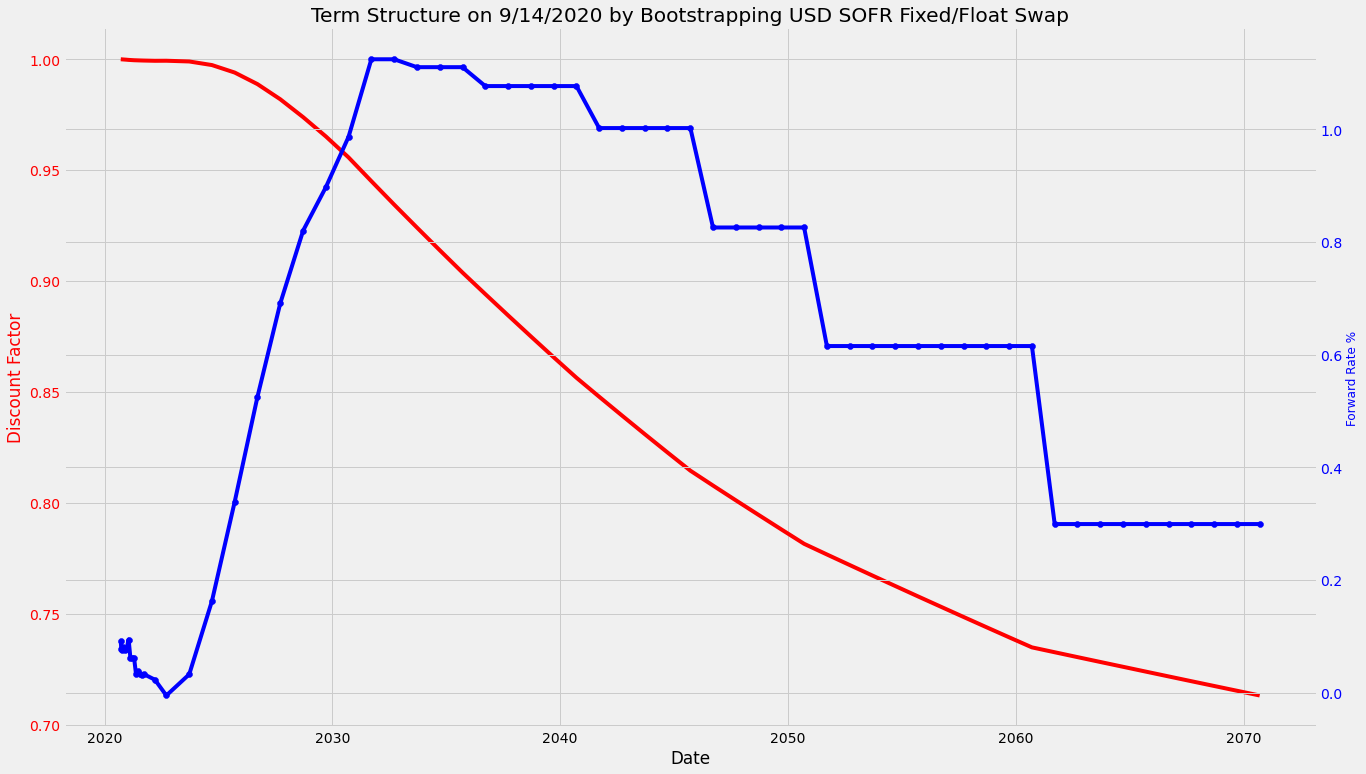

In [27]:
fig, ax1 = plt.subplots(figsize=(20, 12))

ax1.set_xlabel('Date')
ax1.set_ylabel('Discount Factor', color='red')
ax1.plot(x, discount_term_structure, color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  
ax2.set_ylabel('Forward Rate %', color='blue', size = 12) 
ax2.scatter(x, 100*forward_term_structure, color='blue')
ax2.plot(x, 100*forward_term_structure, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Term Structure on 9/14/2020 by Bootstrapping USD SOFR Fixed/Float Swap') 
plt.show()

In [28]:
df_swap.to_excel("term_structure2.xlsx",
             sheet_name='SOFR_TERM_STRUCTURE') 